In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from nbeats_pytorch.model import NBeatsNet

## NBEATS NET

In [2]:
df = pd.read_csv('../data/preprocessed/dataset_ln.csv',index_col='DATE')
df.index = pd.DatetimeIndex(df.index,freq='MS')

df_nparry = df.transpose().to_numpy()[0]

In [3]:
# Define a PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, backcast_length, forecast_length):
        self.data = data
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

    def __len__(self):
        return len(self.data) - self.backcast_length - self.forecast_length

    def __getitem__(self, index):
        x = self.data[index : index + self.backcast_length]
        y = self.data[index + self.backcast_length : index + self.backcast_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters
backcast_length = 30
forecast_length = 7

# Create dataset
dataset = TimeSeriesDataset(df_nparry, backcast_length, forecast_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
# Step 3: Define and Train the N-BEATS Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define N-BEATS model
model = NBeatsNet(
    device=device,
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    hidden_layer_units=128
).to(device)

# Define loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
epochs = 50

for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        backcast, forecast = model(x_batch)
        loss = criterion(forecast, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @1386654564768
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @1386653528656
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @1386653528016
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @1386653399680
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @1386653400288
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @1386653400592
Epoch 10/50, Loss: 0.01670750044286251
Epoch 20/50, Loss: 0.01587367057800293
Epoch 30/50, Loss: 0.015243781730532646
Epoch 40/5

In [5]:
# Step 4: Visualize Backcast, Forecast, and Model Weights
model.eval()
x_batch, y_batch = next(iter(dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

with torch.no_grad():
    backcast, forecast = model(x_batch)

# Convert to numpy for plotting
backcast = backcast.cpu().numpy()
forecast = forecast.cpu().numpy()
x_batch = x_batch.cpu().numpy()
y_batch = y_batch.cpu().numpy()

Plotting the backcast, forecast, and model weights.In the following plot each color represents:
- **Blue line:** backcast input, historical data
- **Green line:** shows the models backcast, so how well the model reconstructs past data points 
- **Orange line:** indicates the actual forecast 
- **Red Line:** depicts the model's forecast

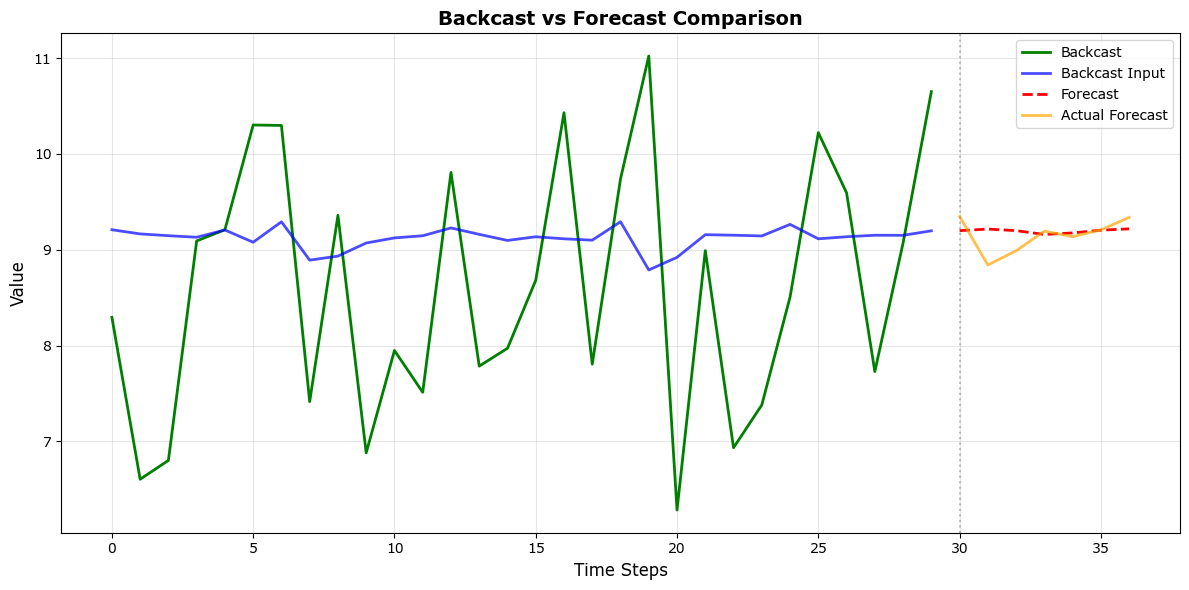

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting a sample:
backcastSample = backcast[0]
forecastSample = forecast[0]
x_batchSample = x_batch[0]
y_batchSample = y_batch[0]

# Get the lengths
backcast_len = len(backcastSample)
forecast_len = len(forecastSample)

# Create time indices
backcast_time = np.arange(backcast_len)
forecast_time = np.arange(backcast_len, backcast_len + forecast_len)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot backcast and x_batch (historical data)
plt.plot(backcast_time, backcastSample, label='Backcast', linewidth=2, color='green')
plt.plot(backcast_time, x_batchSample, label='Backcast Input', linewidth=2, color='blue', alpha=0.7)

# Plot forecast and y_batch (future data)
plt.plot(forecast_time, forecastSample, label='Forecast', linewidth=2, color='red', linestyle='--')
plt.plot(forecast_time, y_batchSample, label='Actual Forecast', linewidth=2, color='orange', alpha=0.7)

# Add a vertical line to separate historical and forecast
plt.axvline(x=backcast_len, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

# Labels and legend
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Backcast vs Forecast Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## Imporving using optima

In [5]:
import optuna

# Split data into train and validation sets
def train_val_split(df_nparry, train_ratio=0.8):
    split_idx = int(len(df_nparry) * train_ratio)
    train_data = df_nparry[:split_idx]
    val_data = df_nparry[split_idx:]
    return train_data, val_data

train_data, val_data = train_val_split(df_nparry)

c:\Users\gerar\OneDrive\Desktop\alcoholSalesProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def objective(trial):
    # Suggest hyperparameters
    backcast_length = trial.suggest_categorical('backcast_length', [10, 15, 30])
    forecast_length = trial.suggest_categorical('forecast_length', [5, 7])
    hidden_layer_units = trial.suggest_categorical('hidden_layer_units', [64, 128, 256])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [50, 100, 200])
    
    # Create datasets with current hyperparameters
    train_dataset = TimeSeriesDataset(train_data, backcast_length, forecast_length)
    val_dataset = TimeSeriesDataset(val_data, backcast_length, forecast_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = NBeatsNet(
        device=device,
        stack_types=(NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=hidden_layer_units
    ).to(device)
    
    # Define loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            backcast, forecast = model(x_batch)
            loss = criterion(forecast, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                backcast, forecast = model(x_batch)
                loss = criterion(forecast, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
    
    # Return final validation loss
    return val_loss

In [ ]:
# Create study and optimize
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

print("Starting hyperparameter optimization...")
study.optimize(objective, n_trials=50, timeout=None)


[I 2025-10-19 19:18:18,219] A new study created in memory with name: no-name-0d18362a-3742-45a4-9fa2-9e495534ee96


Starting hyperparameter optimization...
| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030755904
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030547152
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=5, share_thetas=True) at @2941031546960
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030756240
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=10, forecast_length=5, share_thetas=True) at @2941031547280
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=10, forecast_length=5, share_thetas=True) at @2941031547600


[I 2025-10-19 19:18:22,869] Trial 0 finished with value: 0.005401280242949724 and parameters: {'backcast_length': 10, 'forecast_length': 5, 'hidden_layer_units': 64, 'learning_rate': 0.0014221004031375792, 'batch_size': 64, 'epochs': 100}. Best is trial 0 with value: 0.005401280242949724.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511760
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512064
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512368
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512672
     | -- SeasonalityBlock(units=128, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
     | -- SeasonalityBlock(units=128, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280


[I 2025-10-19 19:18:25,549] Trial 1 finished with value: 0.019224321469664574 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 128, 'learning_rate': 0.014714652535705513, 'batch_size': 64, 'epochs': 50}. Best is trial 0 with value: 0.005401280242949724.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030512064
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030512368
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030512672
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030512976
     | -- SeasonalityBlock(units=128, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030511152


[I 2025-10-19 19:18:44,581] Trial 2 finished with value: 0.06123947352170944 and parameters: {'backcast_length': 15, 'forecast_length': 5, 'hidden_layer_units': 128, 'learning_rate': 0.034445076323218846, 'batch_size': 32, 'epochs': 200}. Best is trial 0 with value: 0.005401280242949724.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511760
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513888


[I 2025-10-19 19:19:28,039] Trial 3 finished with value: 699.9759826660156 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 256, 'learning_rate': 0.018909352847144095, 'batch_size': 16, 'epochs': 200}. Best is trial 0 with value: 0.005401280242949724.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511760
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513888


[I 2025-10-19 19:19:50,441] Trial 4 finished with value: 0.0631973035633564 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.01608251308127328, 'batch_size': 16, 'epochs': 100}. Best is trial 0 with value: 0.005401280242949724.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:19:52,678] Trial 5 finished with value: 0.004840976092964411 and parameters: {'backcast_length': 15, 'forecast_length': 5, 'hidden_layer_units': 64, 'learning_rate': 0.0033468454670966354, 'batch_size': 64, 'epochs': 50}. Best is trial 5 with value: 0.004840976092964411.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:01,462] Trial 6 finished with value: 0.0033989845930288234 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.0057902425789663455, 'batch_size': 16, 'epochs': 50}. Best is trial 6 with value: 0.0033989845930288234.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=10, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:06,311] Trial 7 finished with value: 0.004856931045651436 and parameters: {'backcast_length': 10, 'forecast_length': 5, 'hidden_layer_units': 64, 'learning_rate': 0.0027773072103313926, 'batch_size': 64, 'epochs': 100}. Best is trial 6 with value: 0.0033989845930288234.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:13,670] Trial 8 finished with value: 0.03724391758441925 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.014011559166553543, 'batch_size': 64, 'epochs': 100}. Best is trial 6 with value: 0.0033989845930288234.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:30,692] Trial 9 finished with value: 74.81285095214844 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.03686489605878801, 'batch_size': 16, 'epochs': 100}. Best is trial 6 with value: 0.0033989845930288234.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:35,580] Trial 10 finished with value: 0.004336104961112142 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.00526984928056722, 'batch_size': 32, 'epochs': 50}. Best is trial 6 with value: 0.0033989845930288234.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:41,438] Trial 11 finished with value: 0.012759743258357048 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.0066117201127088975, 'batch_size': 32, 'epochs': 50}. Best is trial 6 with value: 0.0033989845930288234.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:46,863] Trial 12 finished with value: 0.008250178536400199 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.005520861714780967, 'batch_size': 32, 'epochs': 50}. Best is trial 6 with value: 0.0033989845930288234.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:20:51,965] Trial 13 finished with value: 0.0028370185755193233 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.0011597470659101242, 'batch_size': 32, 'epochs': 50}. Best is trial 13 with value: 0.0028370185755193233.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:21:02,013] Trial 14 finished with value: 0.002240051981061697 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.0010487556841666467, 'batch_size': 16, 'epochs': 50}. Best is trial 14 with value: 0.002240051981061697.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:21:11,877] Trial 15 finished with value: 0.002311013755388558 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.0010005346461722676, 'batch_size': 16, 'epochs': 50}. Best is trial 14 with value: 0.002240051981061697.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:21:21,457] Trial 16 finished with value: 0.002029654608728985 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.001910990874293903, 'batch_size': 16, 'epochs': 50}. Best is trial 16 with value: 0.002029654608728985.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:22:00,644] Trial 17 finished with value: 2.4746644784731833e+29 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 128, 'learning_rate': 0.09873601961624733, 'batch_size': 16, 'epochs': 200}. Best is trial 16 with value: 0.002029654608728985.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=64, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=64, thetas_dim=7, backcast_length=10, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:22:09,115] Trial 18 finished with value: 0.0032897912121067443 and parameters: {'backcast_length': 10, 'forecast_length': 7, 'hidden_layer_units': 64, 'learning_rate': 0.002091711319566862, 'batch_size': 16, 'epochs': 50}. Best is trial 16 with value: 0.002029654608728985.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:22:20,903] Trial 19 finished with value: 0.0017719566239975393 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.002032338690503484, 'batch_size': 16, 'epochs': 50}. Best is trial 19 with value: 0.0017719566239975393.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:23:10,147] Trial 20 finished with value: 0.0015207393444143236 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0020496045235684694, 'batch_size': 16, 'epochs': 200}. Best is trial 20 with value: 0.0015207393444143236.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:23:53,240] Trial 21 finished with value: 0.001689207332674414 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.002110050565036466, 'batch_size': 16, 'epochs': 200}. Best is trial 20 with value: 0.0015207393444143236.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:24:37,015] Trial 22 finished with value: 0.0012673264427576214 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.003308054752789415, 'batch_size': 16, 'epochs': 200}. Best is trial 22 with value: 0.0012673264427576214.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:25:19,317] Trial 23 finished with value: 0.0009552855044603348 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0035469347813056494, 'batch_size': 16, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:26:01,157] Trial 24 finished with value: 0.0022607770515605807 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0035797398516376777, 'batch_size': 16, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:26:42,913] Trial 25 finished with value: 446517.703125 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.009234486490603598, 'batch_size': 16, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:27:27,156] Trial 26 finished with value: 0.0014091473130974919 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0038568835767094586, 'batch_size': 16, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:28:09,392] Trial 27 finished with value: 0.0019111167639493942 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0041406639811412856, 'batch_size': 16, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:28:52,037] Trial 28 finished with value: 0.0036549115320667624 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.009254979315533155, 'batch_size': 16, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:29:34,547] Trial 29 finished with value: 7.5756995677948 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 256, 'learning_rate': 0.0030447148444481837, 'batch_size': 16, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:29:48,070] Trial 30 finished with value: 0.001305868267081678 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0014892173913783294, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:30:02,229] Trial 31 finished with value: 0.001078505185432732 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0015428325670332561, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:30:16,012] Trial 32 finished with value: 0.0017947498708963394 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0014495492207524177, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:30:29,710] Trial 33 finished with value: 0.0023252780083566904 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0014768156174094662, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:30:43,400] Trial 34 finished with value: 0.0016503133811056614 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 256, 'learning_rate': 0.002700361561181091, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:30:57,146] Trial 35 finished with value: 0.0011969540501013398 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0015946439922571928, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511760


[I 2025-10-19 19:31:05,978] Trial 36 finished with value: 0.0013731992803514004 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 64, 'learning_rate': 0.004576016503188893, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511760


[I 2025-10-19 19:31:19,810] Trial 37 finished with value: 0.0012742436956614256 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0026848107896886688, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:31:33,376] Trial 38 finished with value: 0.0016103001544252038 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 256, 'learning_rate': 0.0013384281737667588, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:31:40,584] Trial 39 finished with value: 0.01514184195548296 and parameters: {'backcast_length': 30, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.007538607521621849, 'batch_size': 64, 'epochs': 100}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=64, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=64, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:31:49,990] Trial 40 finished with value: 0.0013772060628980398 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 64, 'learning_rate': 0.001709244305073785, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:32:03,913] Trial 41 finished with value: 0.001935378066264093 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.002600131643967878, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:32:17,679] Trial 42 finished with value: 0.0012717905919998884 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0024509890717730478, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:32:32,094] Trial 43 finished with value: 0.001318239839747548 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0023607975203227445, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:32:46,496] Trial 44 finished with value: 0.002954583615064621 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0033098509929048933, 'batch_size': 64, 'epochs': 200}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=7, backcast_length=15, forecast_length=7, share_thetas=True) at @2941030511456


[I 2025-10-19 19:32:53,715] Trial 45 finished with value: 0.0012207675026729703 and parameters: {'backcast_length': 15, 'forecast_length': 7, 'hidden_layer_units': 256, 'learning_rate': 0.0017293255402777094, 'batch_size': 64, 'epochs': 100}. Best is trial 23 with value: 0.0009552855044603348.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:33:06,666] Trial 46 finished with value: 0.0008024646667763591 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 256, 'learning_rate': 0.0012403393645262744, 'batch_size': 32, 'epochs': 100}. Best is trial 46 with value: 0.0008024646667763591.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:33:19,271] Trial 47 finished with value: 0.0013829328818246722 and parameters: {'backcast_length': 30, 'forecast_length': 5, 'hidden_layer_units': 256, 'learning_rate': 0.0012071288918379542, 'batch_size': 32, 'epochs': 100}. Best is trial 46 with value: 0.0008024646667763591.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=64, thetas_dim=5, backcast_length=15, forecast_length=5, share_thetas=True) at @2941030511456


[I 2025-10-19 19:33:28,014] Trial 48 finished with value: 0.023368999361991882 and parameters: {'backcast_length': 15, 'forecast_length': 5, 'hidden_layer_units': 64, 'learning_rate': 0.02433506728191915, 'batch_size': 32, 'epochs': 100}. Best is trial 46 with value: 0.0008024646667763591.


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510544
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030510240
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030512976
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030513280
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511152
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @2941030511456


In [13]:
# Print results
print("\n" + "="*50)
print("Optimization Results")
print("="*50)
print(f"\nBest trial value (validation loss): {study.best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Visualize optimization history (optional)
print("\n" + "="*50)
print("Top 5 Trials")
print("="*50)
trials_df = study.trials_dataframe().sort_values('value').head(5)
print(trials_df[['number', 'value', 'params_backcast_length', 'params_forecast_length', 
                  'params_hidden_layer_units', 'params_learning_rate', 
                  'params_batch_size', 'params_epochs']])

# Train final model with best hyperparameters
print("\n" + "="*50)
print("Training final model with best hyperparameters...")
print("="*50)

best_params = study.best_trial.params


Optimization Results

Best trial value (validation loss): 0.000802

Best hyperparameters:
  backcast_length: 30
  forecast_length: 5
  hidden_layer_units: 256
  learning_rate: 0.0012403393645262744
  batch_size: 32
  epochs: 100

Top 5 Trials
    number     value  params_backcast_length  params_forecast_length  \
46      46  0.000802                      30                       5   
23      23  0.000955                      30                       7   
31      31  0.001079                      30                       7   
35      35  0.001197                      30                       7   
45      45  0.001221                      15                       7   

    params_hidden_layer_units  params_learning_rate  params_batch_size  \
46                        256              0.001240                 32   
23                        256              0.003547                 16   
31                        256              0.001543                 64   
35                        2

### Optimization Results


Best trial value (validation loss): 0.000802

Best hyperparameters:
- backcast_length: 30
- forecast_length: 5
- hidden_layer_units: 256
- learning_rate: 0.0012403393645262744
- batch_size: 32
- epochs: 100

In [10]:
best_params = {
    'backcast_length':30,
    'forecast_length':5,
    'hidden_layer_units':256,
    'learning_rate':0.0012403393645262744,
    'batch_size':32,
    'epochs':100
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [11]:
# Create final dataset
final_dataset = TimeSeriesDataset(df_nparry, 
                                   best_params['backcast_length'], 
                                   best_params['forecast_length'])
final_loader = DataLoader(final_dataset, 
                          batch_size=best_params['batch_size'], 
                          shuffle=True)

# Create final model
stack_types = (NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK)

final_model = NBeatsNet(
    device=device,
    stack_types=stack_types,
    forecast_length=best_params['forecast_length'],
    backcast_length=best_params['backcast_length'],
    hidden_layer_units=best_params['hidden_layer_units']
).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

# Train final model
for epoch in range(best_params['epochs']):
    final_model.train()
    epoch_loss = 0.0
    
    for x_batch, y_batch in final_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        backcast, forecast = final_model(x_batch)
        loss = criterion(forecast, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        avg_loss = epoch_loss / len(final_loader)
        print(f'Epoch {epoch + 1}/{best_params["epochs"]}, Loss: {avg_loss:.6f}')

print("\nTraining complete!")

| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @1568701349968
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @1568706579024
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=30, forecast_length=5, share_thetas=True) at @1568699710544
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @1568701353328
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @1568706580624
     | -- SeasonalityBlock(units=256, thetas_dim=5, backcast_length=30, forecast_length=5, share_thetas=True) at @1568706580304
Epoch 10/100, Loss: 0.004452
Epoch 20/100, Loss: 0.001997
Epoch 30/100, Loss: 0.002483
Epoch 40/100, Loss: 0.001655
Epoch 50/1

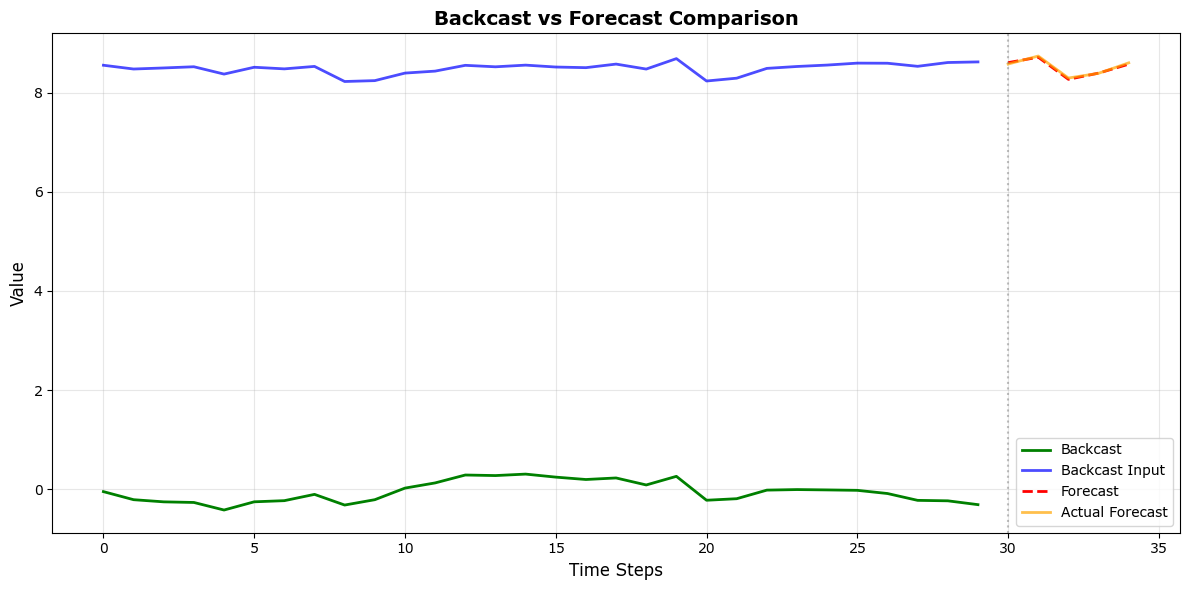

In [13]:
final_model.eval()
x_batch, y_batch = next(iter(final_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

with torch.no_grad():
    backcast, forecast = final_model(x_batch)

# Convert to numpy for plotting
backcast = backcast.cpu().numpy()
forecast = forecast.cpu().numpy()
x_batch = x_batch.cpu().numpy()
y_batch = y_batch.cpu().numpy()

# Plotting a sample:
backcastSample = backcast[0]
forecastSample = forecast[0]
x_batchSample = x_batch[0]
y_batchSample = y_batch[0]

# Get the lengths
backcast_len = len(backcastSample)
forecast_len = len(forecastSample)

# Create time indices
backcast_time = np.arange(backcast_len)
forecast_time = np.arange(backcast_len, backcast_len + forecast_len)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot backcast and x_batch (historical data)
plt.plot(backcast_time, backcastSample, label='Backcast', linewidth=2, color='green')
plt.plot(backcast_time, x_batchSample, label='Backcast Input', linewidth=2, color='blue', alpha=0.7)

# Plot forecast and y_batch (future data)
plt.plot(forecast_time, forecastSample, label='Forecast', linewidth=2, color='red', linestyle='--')
plt.plot(forecast_time, y_batchSample, label='Actual Forecast', linewidth=2, color='orange', alpha=0.7)

# Add a vertical line to separate historical and forecast
plt.axvline(x=backcast_len, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

# Labels and legend
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Backcast vs Forecast Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()